# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.applications import InceptionV3
from nltk.translate.bleu_score import sentence_bleu
import copy
import matplotlib.pyplot as plt
import joblib
import copy


# Image Preprocessing

### Load Images

In [2]:
images_path = '../Images/'
images = glob(images_path+'*.jpg')
print("No. of Images: ", len(images))
print("List View: ", images[:5])


No. of Images:  8091
List View:  ['../Images\\1000268201_693b08cb0e.jpg', '../Images\\1001773457_577c3a7d70.jpg', '../Images\\1002674143_1b742ab4b8.jpg', '../Images\\1003163366_44323f5815.jpg', '../Images\\1007129816_e794419615.jpg']


### View Sample Images

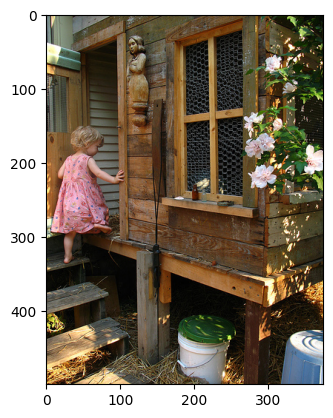

In [3]:
# for i in range(5):
plt.figure()
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


# CNN Model for Feature Extraction

### Load Model

In [4]:
base_model = InceptionV3(include_top=True)
base_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### Configure Model

In [5]:
from keras.models import Model
last = base_model.layers[-2].output
main_model = Model(inputs=base_model.input, outputs=last)
main_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Feature Extraction

In [6]:
images_features = {}
count = 0
TOTAL_NO_OF_IMAGES = len(images)
TRAIN = 6000
TEST = TOTAL_NO_OF_IMAGES - TRAIN
SAVE = 'features_'+str(TRAIN)+'.joblib'

if os.path.exists(SAVE):
    images_features = joblib.load(SAVE)
else:
    for i in images:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))

        img = img.reshape(1, 299, 299, 3)
        pred = main_model.predict(img).reshape(2048,)

        img_name = i.split('\\')[-1]

        images_features[img_name] = pred

        count += 1

        if count > TRAIN:
            break

    joblib.dump(images_features, SAVE)

print("Number of Features: ", len(images_features))


1/1 [==============================] - 0s 76ms/step
Number of Features:  6001


# Text Preprocessing

### Load Captions

In [7]:
caption_path = '../captions.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
print("No. of Captions: ", len(captions))
print(captions[1].split(',')[1])


No. of Captions:  40457
A child in a pink dress is climbing up a set of stairs in an entry way .


### Map Images to Captions

In [8]:
captions_dict = {}
# reference_dict = copy.deepcopy(captions_dict)
for i in captions:
    try:
        img_name = i.split(',')[0]
        caption = i.split(',')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]

            else:
                captions_dict[img_name].append(caption)

    except:
        pass

reference_dict = copy.deepcopy(captions_dict)
len(captions_dict)


6001

In [9]:
for k, v in reference_dict.items():
    for x in range(len(reference_dict[k])):
        reference_dict[k][x] = reference_dict[k][x].split()
# reference_dict['Images\\1000268201_693b08cb0e.jpg']


### Visualize Images with Captions

../Images/1000268201_693b08cb0e.jpg


) missing from current font.ng\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.ng\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


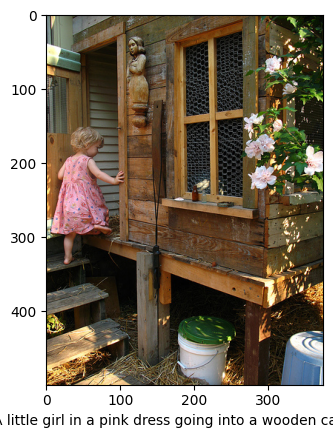

In [10]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()

    img_name = '../Images/' + k
    # img_name = k

    img = cv2.imread(img_name)
    print(img_name)
    # print(captions_dict[k][-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[k][-1])
    plt.imshow(img)

    break


### Preprocess Captions

In [11]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified


for k, v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)


### Create Vocabulary

In [12]:
count_words = {}
for k, vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

print("Vocab Size: ", len(count_words))


Vocab Size:  7741


### Converting Vocabulary to Integer Vocabulary

In [13]:
THRESH = -1
count = 1
new_dict = {}
for k, v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

print("Vocab Size: ", len(new_dict))


Vocab Size:  7741


In [14]:
print("Before: ", captions_dict['1000268201_693b08cb0e.jpg'])
new_dict['<OUT>'] = len(new_dict)
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])

        captions_dict[k][vv.index(v)] = encoded

print("After: ", captions_dict['1000268201_693b08cb0e.jpg'])


Before:  ['startofseq a child in a pink dress is climbing up a set of stairs in an entry way .\r endofseq', 'startofseq a girl going into a wooden building .\r endofseq', 'startofseq a little girl climbing into a wooden playhouse .\r endofseq', 'startofseq a little girl climbing the stairs to her playhouse .\r endofseq', 'startofseq a little girl in a pink dress going into a wooden cabin .\r endofseq']
After:  [[1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 2, 10, 11, 12, 4, 13, 14, 15, 16, 17], [1, 2, 18, 19, 20, 2, 21, 22, 16, 17], [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17], [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17], [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]]


# Generator Function

In [15]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)

print("Max Length of a Word: ", MAX_LEN)

Batch_size = 5000
VOCAB_SIZE = len(new_dict)


def generator(photo, caption):
    n_samples = 0

    X = []
    y_in = []
    y_out = []

    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq = [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(
                    in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)

    return X, y_in, y_out


Max Length of a Word:  36


In [16]:
X, y_in, y_out = generator(images_features, captions_dict)
len(X), len(y_in), len(y_out)


(366279, 366279, 366279)

In [17]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')


In [18]:
X.shape, y_in.shape, y_out.shape


((366279, 2048), (366279, 36), (366279, 7742))

In [19]:
X[1510]


array([11.691297 ,  1.9552262, 21.132742 , ...,  0.       ,  0.       ,
        2.2356584], dtype=float32)

In [20]:
y_in[2]


array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

# RNN Model for Training and Prediction

### Imports

In [21]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense, LSTM, TimeDistributed, Embedding, Activation, RepeatVector, Concatenate
from keras.models import Sequential, Model


### Configure Model

In [22]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size,
                   output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs=out)

# model.load_weights("mine_model_weights.h5")
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 36, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 128)           990976    
                                                                 
 lstm (LSTM)                 (None, 36, 256)           394240    
                            

### Plot Model

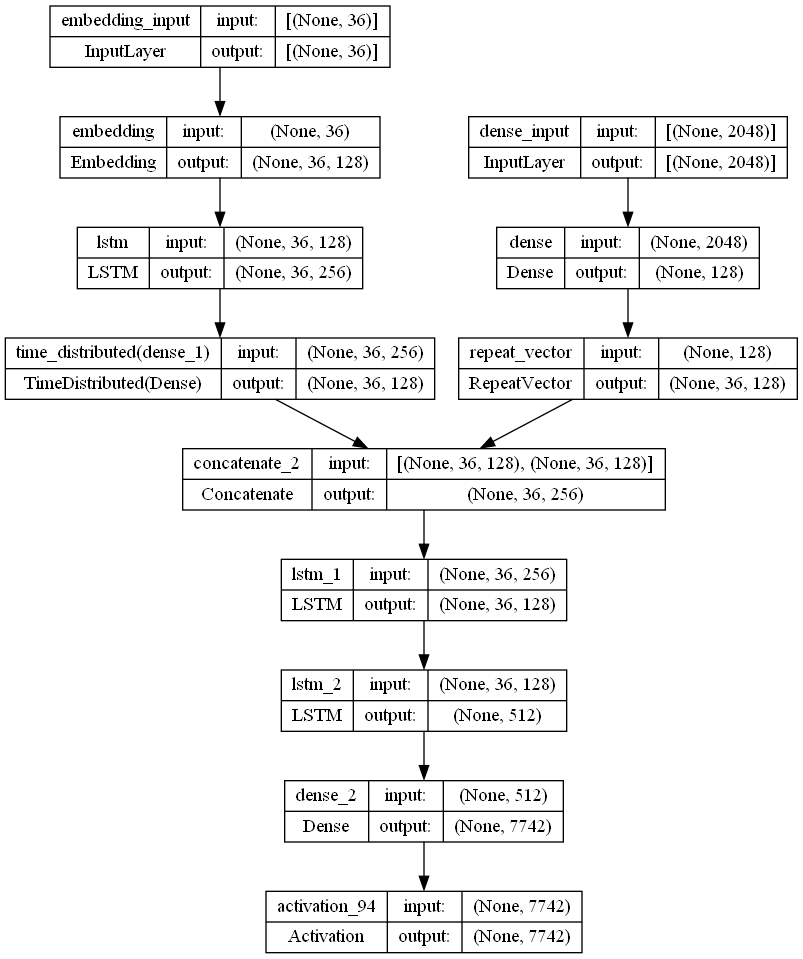

In [23]:
plot_model(model, show_shapes=True)


### Fit Model

In [24]:
EPOCH = 100
BATCH_SIZE = 512
history = model.fit([X, y_in], y_out, batch_size=BATCH_SIZE, epochs=EPOCH)


Epoch 1/100
716/716 [==============================] - 112s 143ms/step - loss: 5.2434 - accuracy: 0.1372
Epoch 2/100
716/716 [==============================] - 102s 142ms/step - loss: 4.5464 - accuracy: 0.2365
Epoch 3/100
716/716 [==============================] - 101s 141ms/step - loss: 4.0313 - accuracy: 0.2968
Epoch 4/100
716/716 [==============================] - 102s 142ms/step - loss: 3.7465 - accuracy: 0.3298
Epoch 5/100
716/716 [==============================] - 102s 142ms/step - loss: 3.5716 - accuracy: 0.3501
Epoch 6/100
716/716 [==============================] - 102s 142ms/step - loss: 3.4589 - accuracy: 0.3624
Epoch 7/100
716/716 [==============================] - 102s 142ms/step - loss: 3.3789 - accuracy: 0.3706
Epoch 8/100
716/716 [==============================] - 102s 142ms/step - loss: 3.3117 - accuracy: 0.3777
Epoch 9/100
716/716 [==============================] - 101s 141ms/step - loss: 3.2605 - accuracy: 0.3829
Epoch 10/100
716/716 [==============================] -

### Save Model

In [25]:
inv_dict = {v: k for k, v in new_dict.items()}  # For Prediction
model.save('model_'+str(TRAIN)+'_'+str(EPOCH)+'E.h5')
model.save_weights('mine_model_weights_'+str(TRAIN)+'_'+str(EPOCH)+'E.h5')
np.save('vocab.npy', new_dict)  # type: ignore


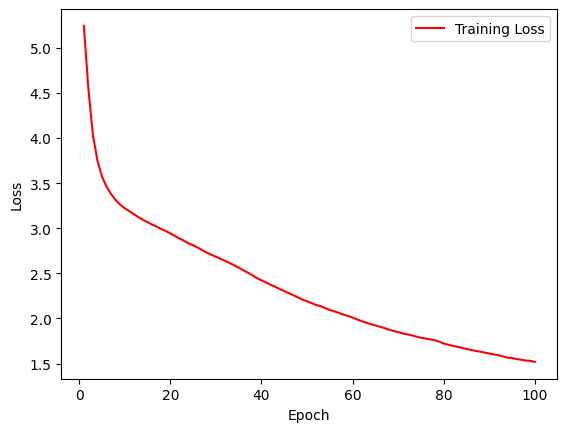

In [26]:
# Get training and test loss histories
training_loss = history.history['loss']
# test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r')
# plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Predictions

In [27]:
def getImage(x):

    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299, 299))

    test_img = np.reshape(test_img, (1, 299, 299, 3))

    return test_img


1/1 [==============================] - 0s 143ms/step


c:\Users\mildi\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 147ms/step


c:\Users\mildi\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 129ms/step


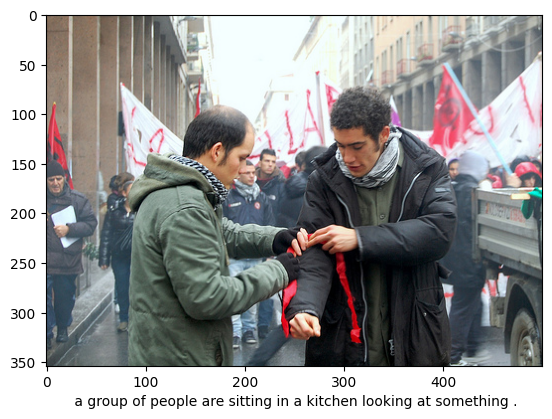

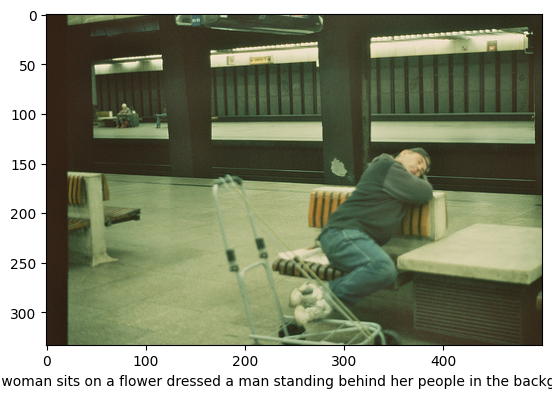

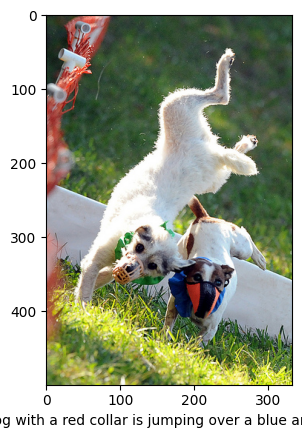

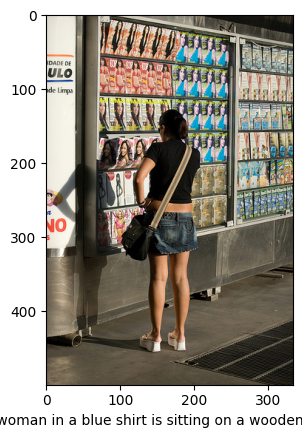

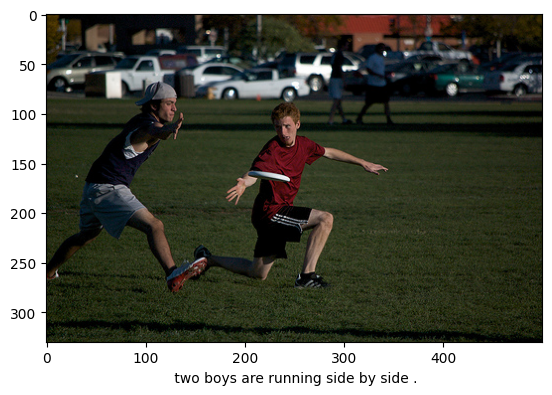

In [28]:
metrics = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
for i in range(5):
    # for i in range(TEST):
    #     no = i
    no = np.random.randint(1500, 6000, (1, 1))[0, 0]
    test_feature = main_model.predict(getImage(no)).reshape(1, 2048)

    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 40:  # Assuming number of words in a caption is not more than 40
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post',
                                truncating='post', maxlen=MAX_LEN)

        # Predicting next word which has Higher Probability
        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        if sampled_word == 'endofseq':
            break

        caption = caption + ' ' + sampled_word

        text_inp.append(sampled_word)

    ref = reference_dict[test_img_path.split('\\')[-1]]
    metrics['BLEU-1'].append(sentence_bleu(ref,
                             caption.split(), weights=(1, 0, 0, 0)))
    metrics['BLEU-2'].append(sentence_bleu(ref,
                             caption.split(), weights=(0.5, 0.5, 0, 0)))
    metrics['BLEU-3'].append(sentence_bleu(ref,
                             caption.split(), weights=(0.33, 0.33, 0.33, 0)))
    metrics['BLEU-4'].append(sentence_bleu(ref,
                             caption.split(), weights=(0.25, 0.25, 0.25, 0.25)))
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)


In [29]:
metrics


{'BLEU-1': [0.6153846153846154,
  0.47058823529411764,
  0.4375,
  0.6153846153846154,
  1.0],
 'BLEU-2': [0.3202563076101743,
  0.24253562503633297,
  0.2958039891549808,
  0.3202563076101743,
  0.8451542547285166],
 'BLEU-3': [0.21378089489770624,
  1.1710502154201404e-102,
  0.18734426618765018,
  0.21378089489770624,
  0.7828303103675857],
 'BLEU-4': [3.7952184850839114e-78,
  7.346153272462044e-155,
  3.434046030282548e-78,
  3.7952184850839114e-78,
  0.6606328636027614]}